In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
from matplotlib import animation
%matplotlib inline

In [2]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,sentences,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,57,12,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,109,15,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [4]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
tfidf1 = TfidfVectorizer(stop_words='english', lowercase=True,binary=True)
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)

# Dimension Reduction
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00568487 0.0085281 ]
3 topics variance ratios: [0.0056849  0.0085289  0.00561196]
4 topics variance ratios: [0.00568492 0.00852811 0.00561126 0.00452166]
5 topics variance ratios: [0.0056849  0.00852825 0.00560148 0.00453147 0.00445436]
6 topics variance ratios: [0.0056849  0.00852824 0.00561209 0.00451305 0.00446137 0.00402167]


# The 2-Topic Result

In [6]:
display_topics(tfidf_lsa[0], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, wires, vodka, thirds, mythology, puzzle, labor, imagining, phrase, action


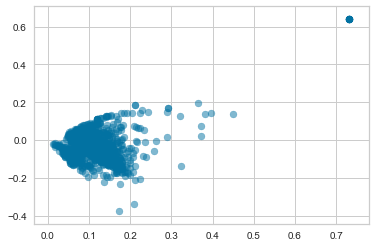

In [7]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

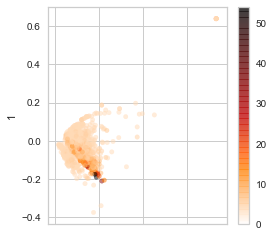

In [8]:
df=pd.DataFrame(tfidf_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

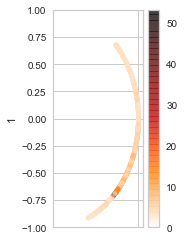

In [9]:
df = pd.DataFrame(normalize(tfidf_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

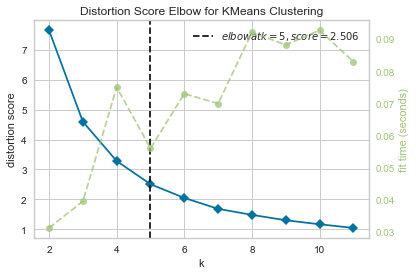

In [10]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(tfidf_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [11]:
visualizer.elbow_value_

5

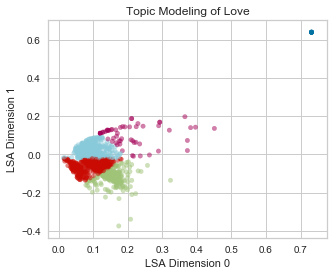

In [12]:
df=pd.DataFrame(tfidf_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [13]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 0.09441608 -0.05957852]
g [ 0.15551675 -0.12248102]
b [0.73172857 0.63876504]
c [0.0940757  0.01610173]
m [0.20929369 0.10170537]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [14]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,tfidf_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.055311,0.045115,0.925573,0.107951,0.190637
1,0.070061,0.095673,0.879808,0.075622,0.138998
2,0.096704,0.158824,0.859083,0.033162,0.110625
3,0.022587,0.065656,0.951300,0.095424,0.207291
4,0.142805,0.055723,0.974809,0.206768,0.271744


Show the snippets from the 4 (euclidean distance) closest documents:

In [15]:
doc_topic = tfidf_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.09441608 -0.05957852] color= r
143 : [ 0.09570076 -0.05905764] Fermi then went on with the same blunt logic to disprove fairies, Sasquatch, God, the possibility of love — and thereafter, as you know, Enrico Fermi ate alone. I loved her, and then she went out into that strange, alien land. And even though, I think you'll agree, it is probable that during the time she was away, she was kidnapped and replaced by an alien clone, I love her and wait for her still.
325 : [ 0.09095346 -0.05869261] But what I love — and I'm a journalist — and what I love is finding hidden patterns; I love being a data detective. And if you're navigating a dense information jungle, coming across a beautiful graphic or a lovely data visualization, it's a relief, it's like coming across a clearing in the jungle. It loves them, and it calls them beautiful. I love taking supplements and being fit, but I can never understand what's going on in terms of evidence. What I love about this image 

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

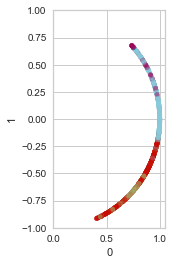

In [16]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [17]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.09441608 -0.05957852] color= r
33 : [ 0.13533399 -0.08535997] I would love to talk about the technology, and sometime, in what's past the 15 minutes, I'll be happy to talk to all the techno-geeks around here about what's in here. I love them all. And again, I say that not to attack any industry, I think — I really do — I love my airplane, and cars on highways moving 60 miles an hour are extraordinarily efficient, both from an engineering point of view, an energy consumption point of view, and a utility point of view. And we all love our cars, and I do. It's just fun, and people love to move around doing fun things. They love it.
278 : [ 0.12833349 -0.08112506] It's got everything that you'd want a normal soap opera to want: It's got love, joy, happiness, sadness, tears, laughter, lots of deceit, intrigue. But there is a reason why India fell in love with cricket: because we had about the same pace of life. Princes patronize the game, not because they love the g

Now clustering on the 

In [ ]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [ ]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [ ]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

# The 3-topic Result

In [27]:
display_topics(tfidf_lsa[1], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, labor, wires, vodka, thirds, mythology, puzzle, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, cook, big, iphone, sailing, sausages


In [28]:
tfidf_doc_topic[1]

array([[ 0.1464601 , -0.07845339,  0.03455977],
       [ 0.15634313, -0.02712171, -0.05195512],
       [ 0.12265356,  0.03294001, -0.01775533],
       ...,
       [ 0.1130805 ,  0.03989971, -0.01219541],
       [ 0.09658057, -0.02294919, -0.0620031 ],
       [ 0.13771002,  0.02613295, -0.0092759 ]])

In [29]:
from mpl_toolkits.mplot3d import Axes3D

In [30]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(tfidf_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

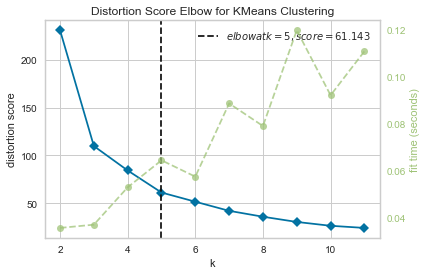

In [31]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [32]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


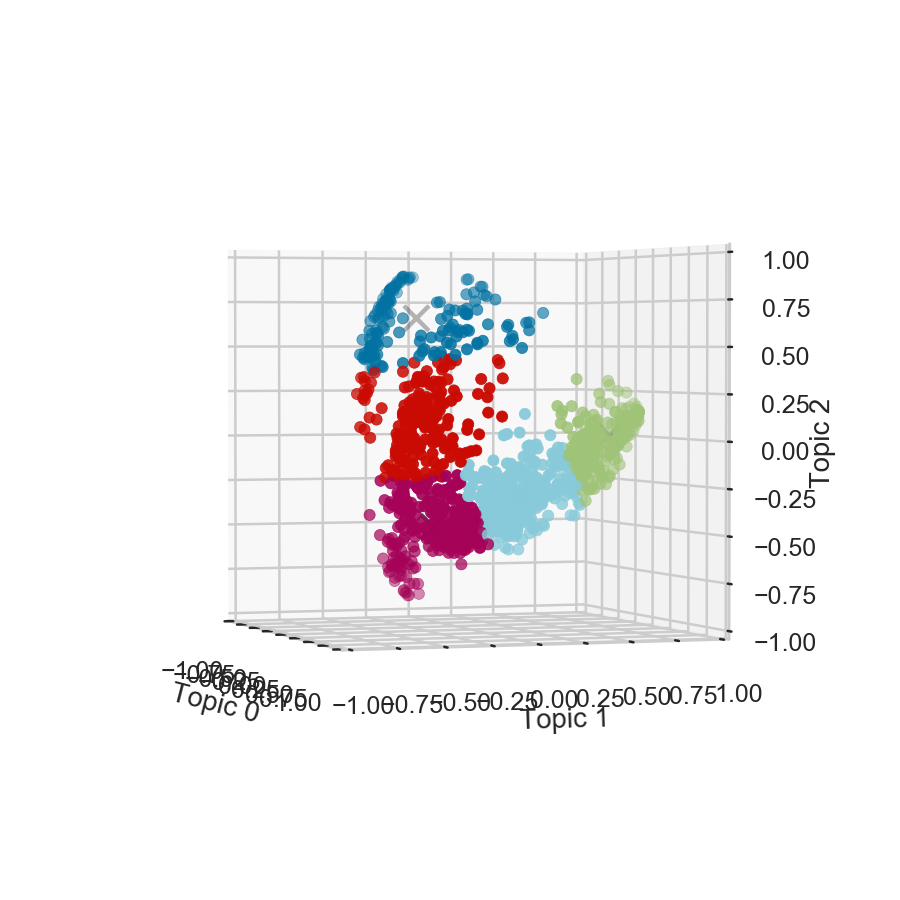

In [33]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=100,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [ ]:
doc_topic = tfidf_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

## DBSCAN Clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
db = DBSCAN(eps=0.055, min_samples=5).fit(df)
labels = db.labels_
np.unique(labels,return_counts=True)
# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

In [ ]:
cmap = {-1: 'k', 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow',10:'fuchsia',11:'purple',12:'brown'}
col = pd.DataFrame(np.array([db.labels_])).transpose()[0].map(cmap)

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=100,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## MeanShift Clustering

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [ ]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(df, quantile=0.09)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)
cluster_centers = ms.cluster_centers_
np.unique(ms.labels_,return_counts=True)

In [ ]:
%matplotlib notebook
col = pd.DataFrame(np.array([ms.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# linkage can be 'ward', 'average' or 'complete'
hc = AgglomerativeClustering(linkage='average', n_clusters=6)
hc.fit(df)

In [ ]:
%matplotlib notebook
col = pd.DataFrame(np.array([hc.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
labels = sc.fit_predict(df)

In [ ]:
%matplotlib notebook
col = pd.DataFrame(np.array([labels])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

# The 4-Topic Result

In [35]:
display_topics(tfidf_lsa[2], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, wires, vodka, puzzle, thirds, mythology, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, big, cook, iphone, sailing, sausages

Topic  3
laughter, picture, loved, applause, make, right, got, told, internet, true, life, ones, does, share


In [36]:
doc_topic = tfidf_doc_topic[2]
df = pd.DataFrame(normalize(tfidf_doc_topic[2]))

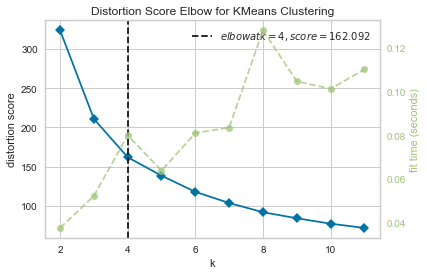

In [37]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [38]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


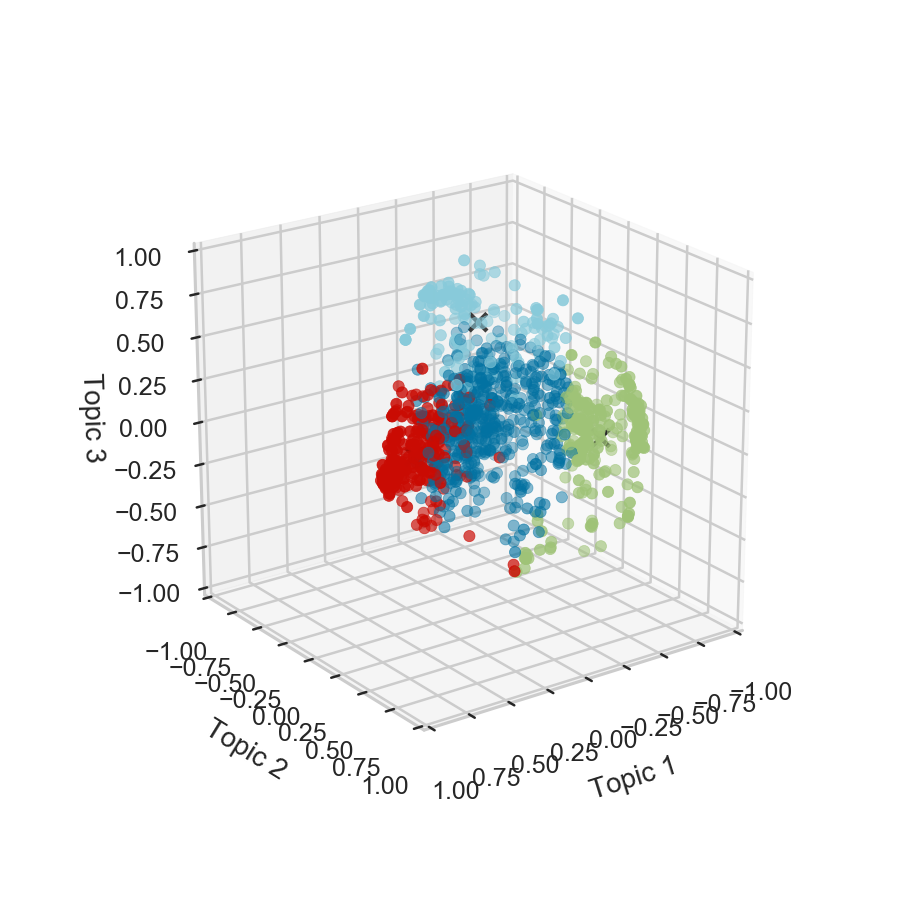

In [41]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=50,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.set_xlabel('\nTopic 1')
ax.set_ylabel('\nTopic 2')
ax.set_zlabel('\nTopic 3')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

In [52]:
plt.__version__

'1.17.2'

<IPython.core.display.Javascript object>


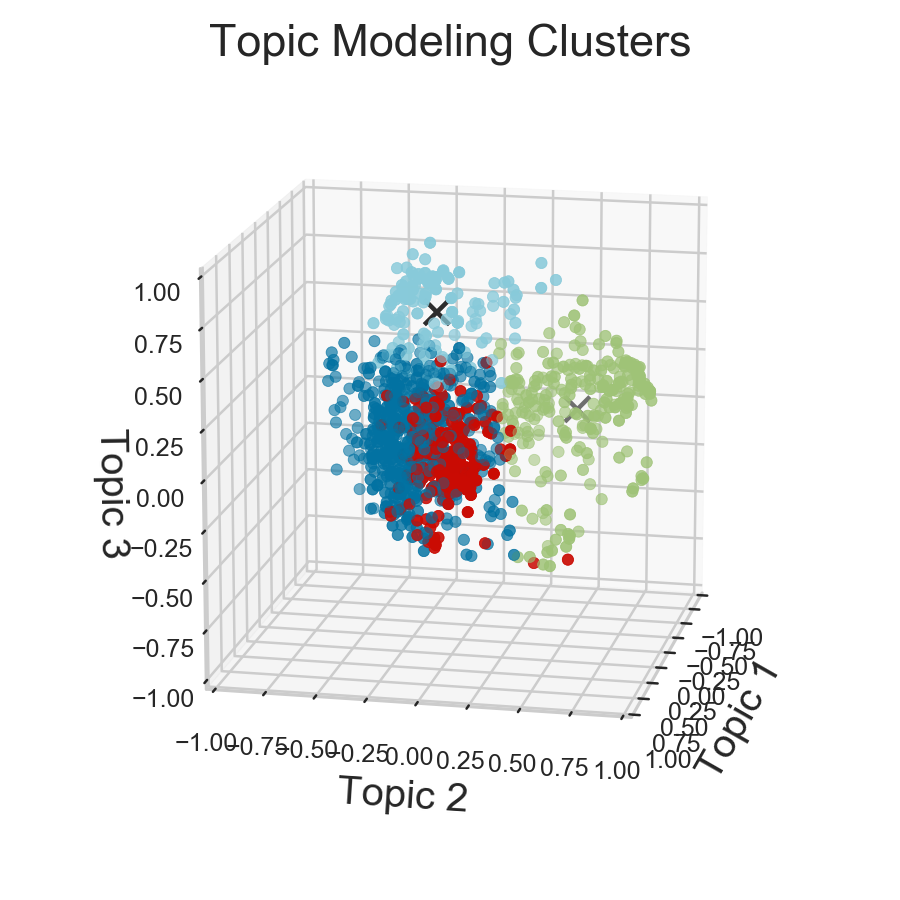

In [53]:
%matplotlib notebook
# Set up formatting for the movie files
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/Cellar/ffmpeg/4.2.1_2/bin/ffmpeg'
Writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Sean Davern'),\
                                bitrate=-1, extra_args=['-vcodec','libx264'])

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, title="Topic Modeling Clusters")
ax.title.set_size(18)
ax.set_xlabel('\nTopic 1', fontsize=16)
ax.set_ylabel('\nTopic 2', fontsize=16)
ax.set_zlabel('\nTopic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
# Create an init function and the animate functions.
# Both are explained in the tutorial:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
# Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function.
def init():
    ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
    ax.scatter(df[1],df[2],df[3],c=col)
    ax.dist = 12
    return fig,

def animate(i):
    ax.view_init(elev=15, azim=-45+i)
    ax.dist = 12
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=10, blit=True,
                               repeat=True)
# Save
# anim.save('./reports/figures/tfidf_binary-lsa_animation.mp4',\
#           writer = Writer, dpi=600)

In [ ]:
doc_topic = tfidf_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')